**Program Description:**

This program is designed to interface with an Arduino via a serial connection to analyze the relationship between servo angles and RPM variations. It allows users to specify a servo’s minimum and maximum angles, as well as the number of iterations for data collection. The Arduino sends back real-time angle and RPM data, which is processed and stored in a CSV file.

The program applies a moving average filter to smooth RPM fluctuations and determines two key parameters: the threshold angle, where the first stable RPM is observed, and the saturation angle, where the RPM reaches its highest steady-state value. The results are visualized in a plot with clear markers for these angles.

To enhance analysis, the plot is saved as a high-resolution vector PDF with dynamic file naming based on threshold and saturation angles. This program is useful for motor control tuning, servo calibration, and performance evaluation.

Enter minimum servo angle: 100
Enter maximum servo angle: 200
Enter number of iterations (datasets required): 4
Connected to Arduino.
Values sent to Arduino. Waiting for data...

Starting iteration 1...
Iteration 1: Angle=100, RPM=1
Iteration 1: Angle=101, RPM=0
Iteration 1: Angle=102, RPM=0
Iteration 1: Angle=103, RPM=0
Iteration 1: Angle=104, RPM=7
Iteration 1: Angle=105, RPM=9
Iteration 1: Angle=106, RPM=2888
Iteration 1: Angle=107, RPM=16927
Iteration 1: Angle=108, RPM=23388
Iteration 1: Angle=109, RPM=29972
Iteration 1: Angle=110, RPM=-30645
Iteration 1: Angle=111, RPM=-27762
Iteration 1: Angle=112, RPM=-25621
Iteration 1: Angle=113, RPM=-23039
Iteration 1: Angle=114, RPM=-20535
Iteration 1: Angle=115, RPM=-18409
Iteration 1: Angle=116, RPM=-17433
Iteration 1: Angle=117, RPM=-16588
Iteration 1: Angle=118, RPM=-15982
Iteration 1: Angle=119, RPM=-15297
Iteration 1: Angle=120, RPM=-13272
Iteration 1: Angle=121, RPM=-10365
Iteration 1: Angle=122, RPM=-8601
Iteration 1: Angle=123, RPM=

Iteration 3: Angle=132, RPM=15929
Iteration 3: Angle=133, RPM=15152
Iteration 3: Angle=134, RPM=14144
Iteration 3: Angle=135, RPM=13384
Iteration 3: Angle=136, RPM=12466
Iteration 3: Angle=137, RPM=12058
Iteration 3: Angle=138, RPM=11509
Iteration 3: Angle=139, RPM=11018
Iteration 3: Angle=140, RPM=10126
Iteration 3: Angle=141, RPM=8986
Iteration 3: Angle=142, RPM=8751
Iteration 3: Angle=143, RPM=8703
Iteration 3: Angle=144, RPM=8364
Iteration 3: Angle=145, RPM=8293
Iteration 3: Angle=146, RPM=8308
Iteration 3: Angle=147, RPM=8152
Iteration 3: Angle=148, RPM=7913
Iteration 3: Angle=149, RPM=8111
Iteration 3: Angle=150, RPM=7987
Iteration 3: Angle=151, RPM=7936
Iteration 3: Angle=152, RPM=8036
Iteration 3: Angle=153, RPM=8148
Iteration 3: Angle=154, RPM=8820
Iteration 3: Angle=155, RPM=9744
Iteration 3: Angle=156, RPM=10188
Iteration 3: Angle=157, RPM=10503
Iteration 3: Angle=158, RPM=10400
Iteration 3: Angle=159, RPM=10206
Iteration 3: Angle=160, RPM=10270
Iteration 3: Angle=161, RPM=1

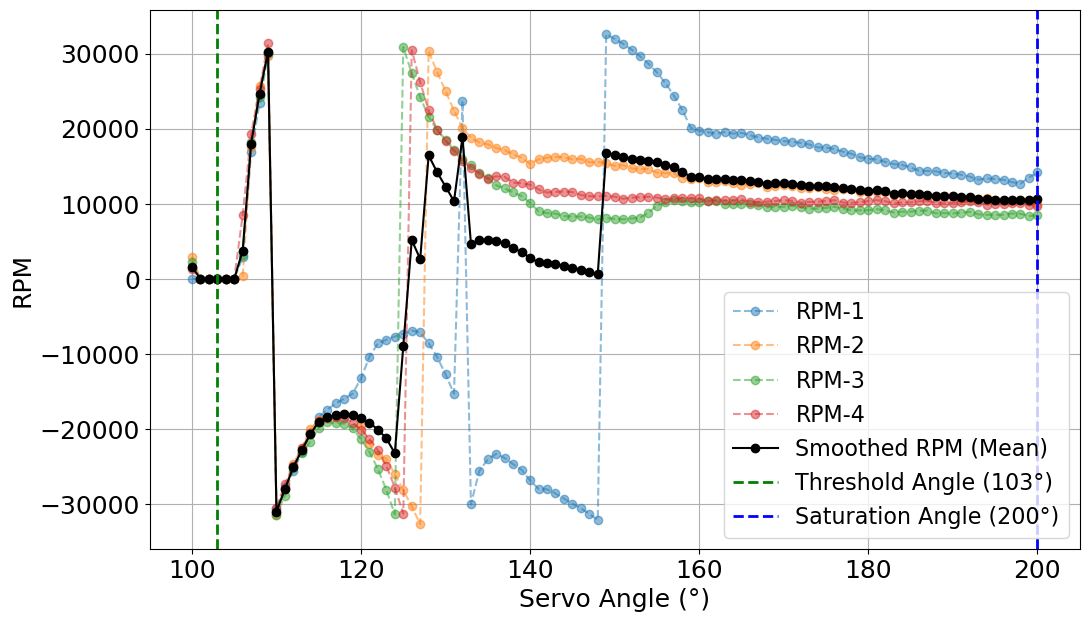

Threshold Angle: 103°
Saturation Angle: 200°
Plot saved as: Servo_RPM_Threshold_103_Saturation_200.pdf


In [1]:
import serial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import matplotlib 
from datetime import datetime

# Set font sizes for the plots
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)

# Serial port configuration
SERIAL_PORT = "COM3"  # Ensure this matches your actual port
BAUD_RATE = 115200

# Stability parameters
MOVING_AVERAGE_WINDOW = 5  # Smoothing filter window
STABILITY_CHECK_WINDOW = 3  # Consecutive stable points for saturation angle
RPM_VARIATION_THRESHOLD = 0.02  # % Change threshold to detect stabilization
LINEAR_ANGLE_STEP = 10  # Angle range over which linearity is checked

# Get user input for control parameters
min_angle = int(input("Enter minimum servo angle: "))
max_angle = int(input("Enter maximum servo angle: "))
num_iterations = int(input("Enter number of iterations (datasets required): "))

# Initialize storage for received data
angles = []
rpm_data = {f"RPM-{i+1}": [] for i in range(num_iterations)}

# Open serial connection
try:
    ser = serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=1)
    time.sleep(2)  # Allow connection time
    print("Connected to Arduino.")

    # Send values to Arduino
    ser.write(f"{min_angle},{max_angle},{num_iterations}\n".encode())
    print("Values sent to Arduino. Waiting for data...")

except serial.SerialException:
    print(f"Error: Could not open serial port {SERIAL_PORT}.")
    exit()

# Moving average function
def moving_average(data, window):
    return np.convolve(data, np.ones(window) / window, mode="valid") if len(data) >= window else np.mean(data)

# Data collection
current_iteration = 0
try:
    while current_iteration < num_iterations:
        temp_angles = []
        temp_rpms = []

        print(f"\nStarting iteration {current_iteration + 1}...")

        while True:
            line = ser.readline().decode("utf-8").strip()

            # Stop reading if Arduino signals termination
            if "Max iterations reached" in line:
                print("Max iterations reached. Stopping data collection.")
                break

            if "," in line:
                try:
                    angle, rpm = map(int, line.split(","))

                    # Ignore duplicate angles in a single iteration
                    if angle not in temp_angles:
                        temp_angles.append(angle)
                        temp_rpms.append(rpm)
                        print(f"Iteration {current_iteration + 1}: Angle={angle}, RPM={rpm}")

                    # Stop iteration after reaching max angle
                    if angle >= max_angle:
                        break

                except ValueError:
                    continue  # Skip invalid data

        # Ensure angles are stored only once
        if not angles:
            angles.extend(temp_angles)

        # Store collected RPM values (Fixed issue: Using correct variable)
        rpm_data[f"RPM-{current_iteration + 1}"] = temp_rpms

        current_iteration += 1

except KeyboardInterrupt:
    print("\nData collection stopped by user.")

finally:
    ser.close()
    print("Serial connection closed.")

# Convert to DataFrame
df = pd.DataFrame({"angle": angles, **rpm_data})

# Automate CSV file name with today's date
today_date = datetime.today().strftime('%Y-%m-%d')
csv_filename = f"servo_rpm_data_{today_date}.csv"
df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

# Compute filtered RPM (mean of RPM iterations)
filtered_rpms = df.iloc[:, 1:].mean(axis=1)
df["filtered_rpm"] = filtered_rpms

# Ignore first step response and select first nonzero stable RPM as threshold angle
df_nonzero = df[df["filtered_rpm"] > 0].iloc[1:]  # Skip first step response
threshold_angle = df_nonzero["angle"].iloc[0]

# Identify Stable Region Start (where RPM stabilizes)
df["rpm_variation"] = df["filtered_rpm"].diff().abs()
df["rpm_variation"].fillna(0, inplace=True)

stability_threshold = 2  # Define small RPM change for stability
stable_rows = df[df["rpm_variation"] < stability_threshold]

stable_start_angle = stable_rows["angle"].iloc[0] if not stable_rows.empty else df["angle"].iloc[-1]

# Identify Saturation Angle: Most Frequent & Highest RPM in Linear Region
saturation_angle = None
max_rpm = 0

for i in range(len(df) - LINEAR_ANGLE_STEP):
    angle_range = df.iloc[i : i + LINEAR_ANGLE_STEP]

    # Compute slope (change in RPM over angles)
    slope = np.polyfit(angle_range["angle"], angle_range["filtered_rpm"], 1)[0]

    # Check if RPM variation is stable within the range
    if np.all(angle_range["rpm_variation"] < stability_threshold):

        # Get most frequent angle in the stable region
        mode_angle = angle_range["angle"].mode()[0]

        # Find the highest RPM in this range
        peak_rpm = angle_range["filtered_rpm"].max()

        if peak_rpm > max_rpm:
            saturation_angle = mode_angle
            max_rpm = peak_rpm

# Fallback if no valid saturation angle found
if saturation_angle is None:
    saturation_angle = df["angle"].iloc[-1]

# Plot the refined results
plt.figure(figsize=(12, num_iterations+3))

# Plot raw RPM signals
for col in df.columns[1:num_iterations+1]:
    plt.plot(df["angle"], df[col], marker="o", linestyle="--", alpha=0.5, label=f"{col}")

# Plot smoothed RPM
plt.plot(df["angle"], df["filtered_rpm"], marker="o", linestyle="-", color="black", label="Smoothed RPM (Mean)")

# Indicate threshold and saturation angles
plt.axvline(x=threshold_angle, color="g", linestyle="--", label=f"Threshold Angle ({threshold_angle}°)", linewidth=2)
plt.axvline(x=saturation_angle, color="b", linestyle="--", label=f"Saturation Angle ({saturation_angle}°)", linewidth=2)

plt.xlabel("Servo Angle (°)", fontsize=18)
plt.ylabel("RPM", fontsize=18)
plt.legend(loc='lower right', fontsize=16)
plt.grid()

# Save as PDF for vector graphics
pdf_filename = f"Servo_RPM_Threshold_{threshold_angle}_Saturation_{saturation_angle}.pdf"
plt.savefig(pdf_filename, format="pdf", bbox_inches="tight")
plt.show()

# Display final refined angles
print(f"Threshold Angle: {threshold_angle}°")
print(f"Saturation Angle: {saturation_angle}°")
print(f"Plot saved as: {pdf_filename}")


**The Arduino Code:**

#include <Servo.h>

// Servo and Encoder setup
Servo myservo;
const int encoderPin = 2;
volatile unsigned int counter = 0;
unsigned long lastTime = 0;
const long interval = 1000;  // 1 second interval

// Local variables to store received parameters
int min_angle, max_angle, num_iterations;
int angle;

// Flag to check if values are received
bool receivedValues = false;

void setup() {
    myservo.attach(9);
    pinMode(encoderPin, INPUT_PULLUP);
    attachInterrupt(digitalPinToInterrupt(encoderPin), countPulses, RISING);

    Serial.begin(115200);
    Serial.println("Waiting for input...");

    // Wait for values from Python
    while (!receivedValues) {
        if (Serial.available()) {
            String input = Serial.readStringUntil('\n'); // Read full input
            sscanf(input.c_str(), "%d,%d,%d", &min_angle, &max_angle, &num_iterations);
            
            angle = min_angle;  // Start at the min angle
            receivedValues = true; // Mark values as received
            Serial.println("Values received. Starting operation...");
            Serial.println("angle,rpm");  // CSV Header
            delay(2000);
        }
    }
}

void loop() {
    if (millis() - lastTime >= interval && receivedValues && num_iterations > 0) {
        lastTime = millis();
        //int rpm = (counter * 60) / 20;  // Calculate RPM (20 pulses per revolution)
        int rpm = counter;  

        // Send data to Python
        Serial.print(angle);
        Serial.print(",");
        Serial.println(rpm);

        counter = 0;  // Reset counter

        // Move to next angle
        angle += 1;
        if (angle > max_angle) {
            angle = min_angle;  // Restart from min angle if max reached
            num_iterations--;   // Decrement dataset counter
        }

        if (num_iterations == 0) {
            Serial.println("Max iterations reached. Stopping.");
            while (true) {} // Stop execution
        }

        myservo.write(angle);
        delay(1000);
    }
}

void countPulses() {
    counter++;
}
